# **HOMEWORK 2: Stochastic Gradient Descent**

Dataset size: 200 samples, 2 features (including bias)


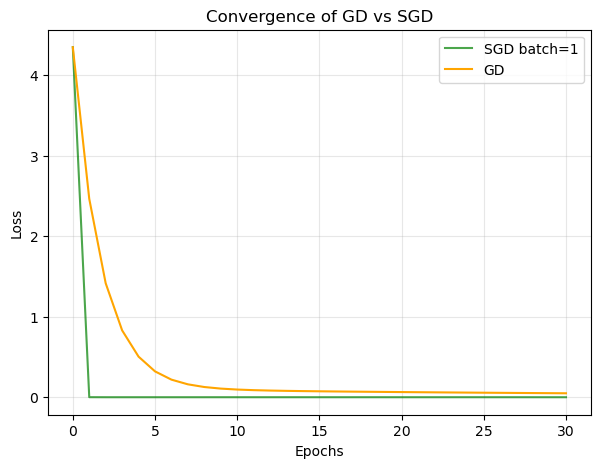

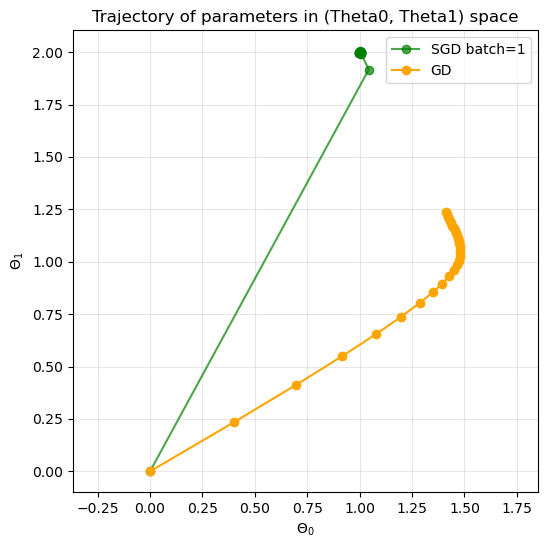

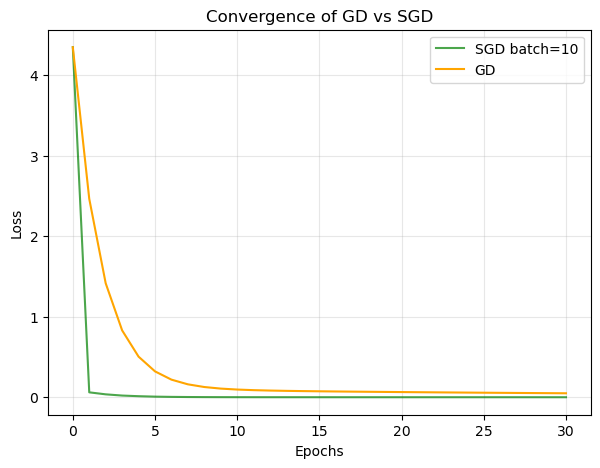

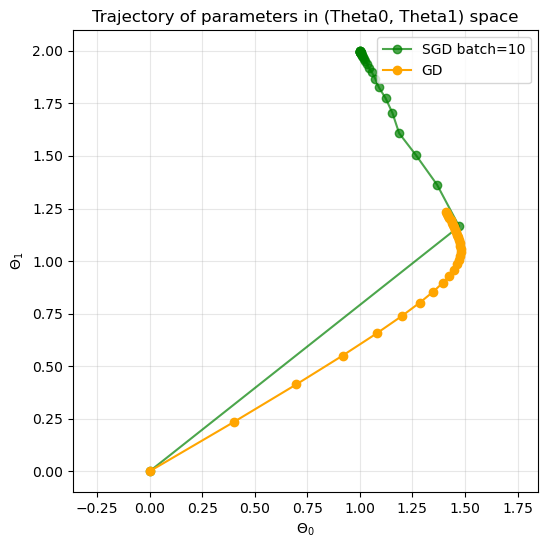

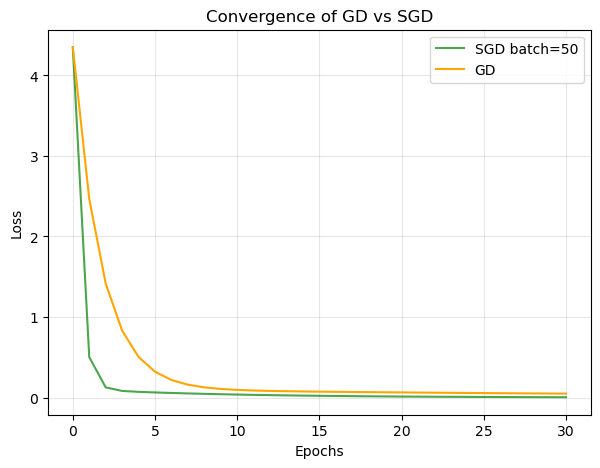

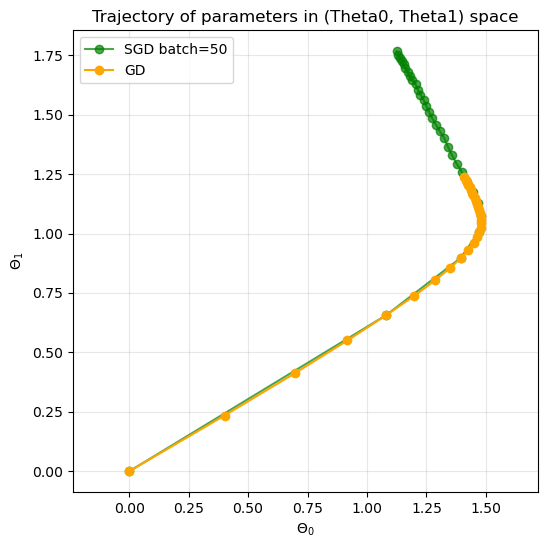

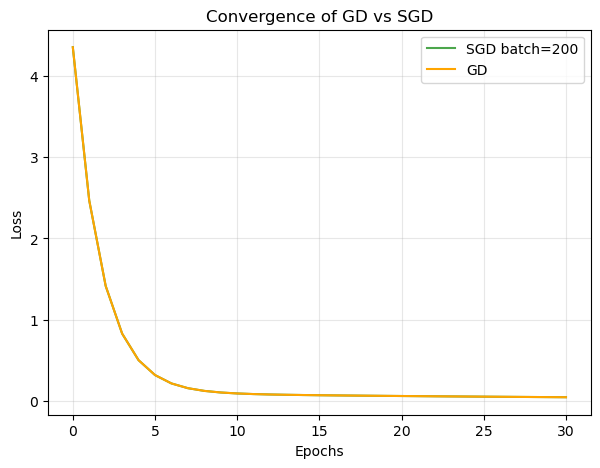

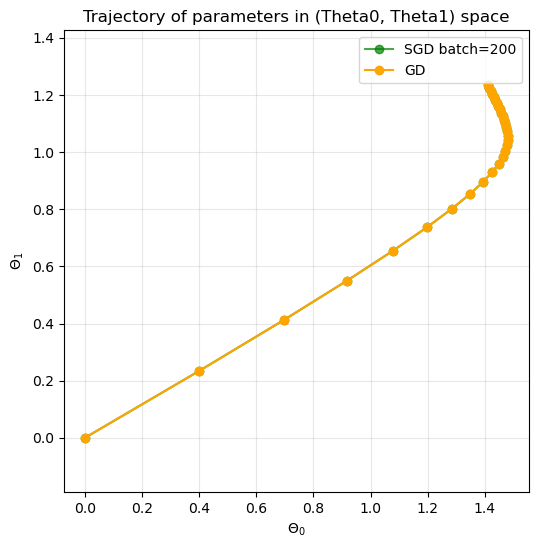

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# EXERCISE1: SGD vs GD on a simple 1D Regression Problem

N = 200
X = (np.arange(1,N+1)/N).reshape(-1,1)
eps = np.random.normal(0,0.01,size=X.shape)
Y = (2 * X + 1 + eps).reshape(-1,1)

X = np.hstack([np.ones((N, 1)), X]) 

print(f"Dataset size: {X.shape[0]} samples, {X.shape[1]} features (including bias)")

def l(Theta, X, Y):
    residuals = X @ Theta - Y
    return (residuals**2).mean()

def grad_l(Theta, X, Y):
    return (2/X.shape[0]) * X.T @ (X @ Theta - Y)

def GD(l, grad_l, Theta0, X, Y, lr=0.1, epochs=30):
    thetas = [Theta0.copy()]
    theta = Theta0.copy()
    losses = [l(theta, X, Y)]
    for k in range(epochs):
        theta = theta - lr * grad_l(theta, X, Y)
        thetas.append(theta.copy())
        losses.append(l(theta,X,Y))
    return np.array(thetas), losses


def SGD(l, grad_l, Theta0, X, Y, batch_size=32, lr=0.1, epochs=30):
    losses = [l(Theta0, X, Y)]
    Theta = Theta0.copy()
    thetas = [Theta.copy()]
    N = X.shape[0]
    
    for epoch in range(epochs):
        indices = np.random.permutation(N)  
        for start in range(0, N, batch_size):
            batch_idx = indices[start : start+batch_size]
            Xb = X[batch_idx]
            Yb = Y[batch_idx]
            g = grad_l(Theta, Xb, Yb)

            Theta = Theta - lr * g
        losses.append(l(Theta, X, Y))
        thetas.append(Theta.copy())
    return np.array(thetas), losses

batch_sizes = [1, 10, 50, N]

Theta_gd, loss_gd = GD(l, grad_l, np.zeros((X.shape[1], 1)), X, Y)

sgd_results = {}
for b in batch_sizes:
    Thetas_sgd, loss_sgd = SGD(l, grad_l, np.zeros((X.shape[1], 1)), X, Y, batch_size=b)
    sgd_results[b] = {"thetas": np.array(Thetas_sgd), "losses": np.array(loss_sgd)}


for b in batch_sizes:
    losses = sgd_results[b]["losses"]
    thetas = sgd_results[b]["thetas"] 

    plt.figure(figsize=(7,5))
    plt.plot(losses, label=f"SGD batch={b}", alpha=0.7, color="green")
    plt.plot(loss_gd, label="GD", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Convergence of GD vs SGD")
    plt.grid(alpha=0.3)

    plt.figure(figsize=(6,6))
    plt.plot(thetas[:,0], thetas[:,1], "o-", label=f"SGD batch={b}", alpha=0.7, color="green")
    plt.plot(Theta_gd[:,0], Theta_gd[:,1], "o-", label="GD", color="orange")
    plt.xlabel(r"$\Theta_0$")   
    plt.ylabel(r"$\Theta_1$")
    plt.title("Trajectory of parameters in (Theta0, Theta1) space")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.axis("equal")
    plt.show()


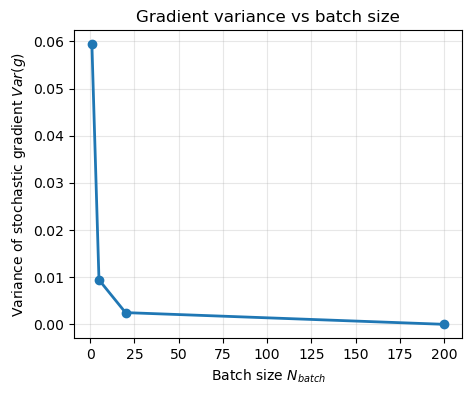

In [33]:
import numpy as np
import matplotlib.pyplot as plt

#EXERCISE2: Variance of the Stochastic Gradient (1D Experiment)

N_batch = [1, 5, 20, N]
Theta_fixed = np.array([[1.0], [2.0]])
K = 100
variances = {}

def grad_l_batch(Theta, X, Y, batch_idx):
    Xb = X[batch_idx]
    Yb = Y[batch_idx] 
    return (2 / len(batch_idx)) * Xb.T @ (Xb @ Theta - Yb) 
    
for b in N_batch:
    gradients = np.zeros((K, 2)) 
    for k in range(K): 
        batch_idx = np.random.choice(N, size=b, replace=False)
        gk = grad_l_batch(Theta_fixed, X, Y, batch_idx)
        gradients[k, :] = gk.ravel()

    g_bar = gradients.mean(axis=0) 
    diffs = gradients - g_bar
    var_g = np.sum(np.linalg.norm(diffs, axis=1)**2).mean()
    variances[b] = var_g

batch_sizes = sorted(variances.keys())
var_values  = [variances[b] for b in batch_sizes]

plt.figure(figsize=(5,4))
plt.plot(batch_sizes, var_values, "o-", linewidth=2)
plt.xlabel("Batch size $N_{batch}$")
plt.ylabel(r"Variance of stochastic gradient $Var(g)$")
plt.title("Gradient variance vs batch size")
plt.grid(alpha=0.3)
plt.show()


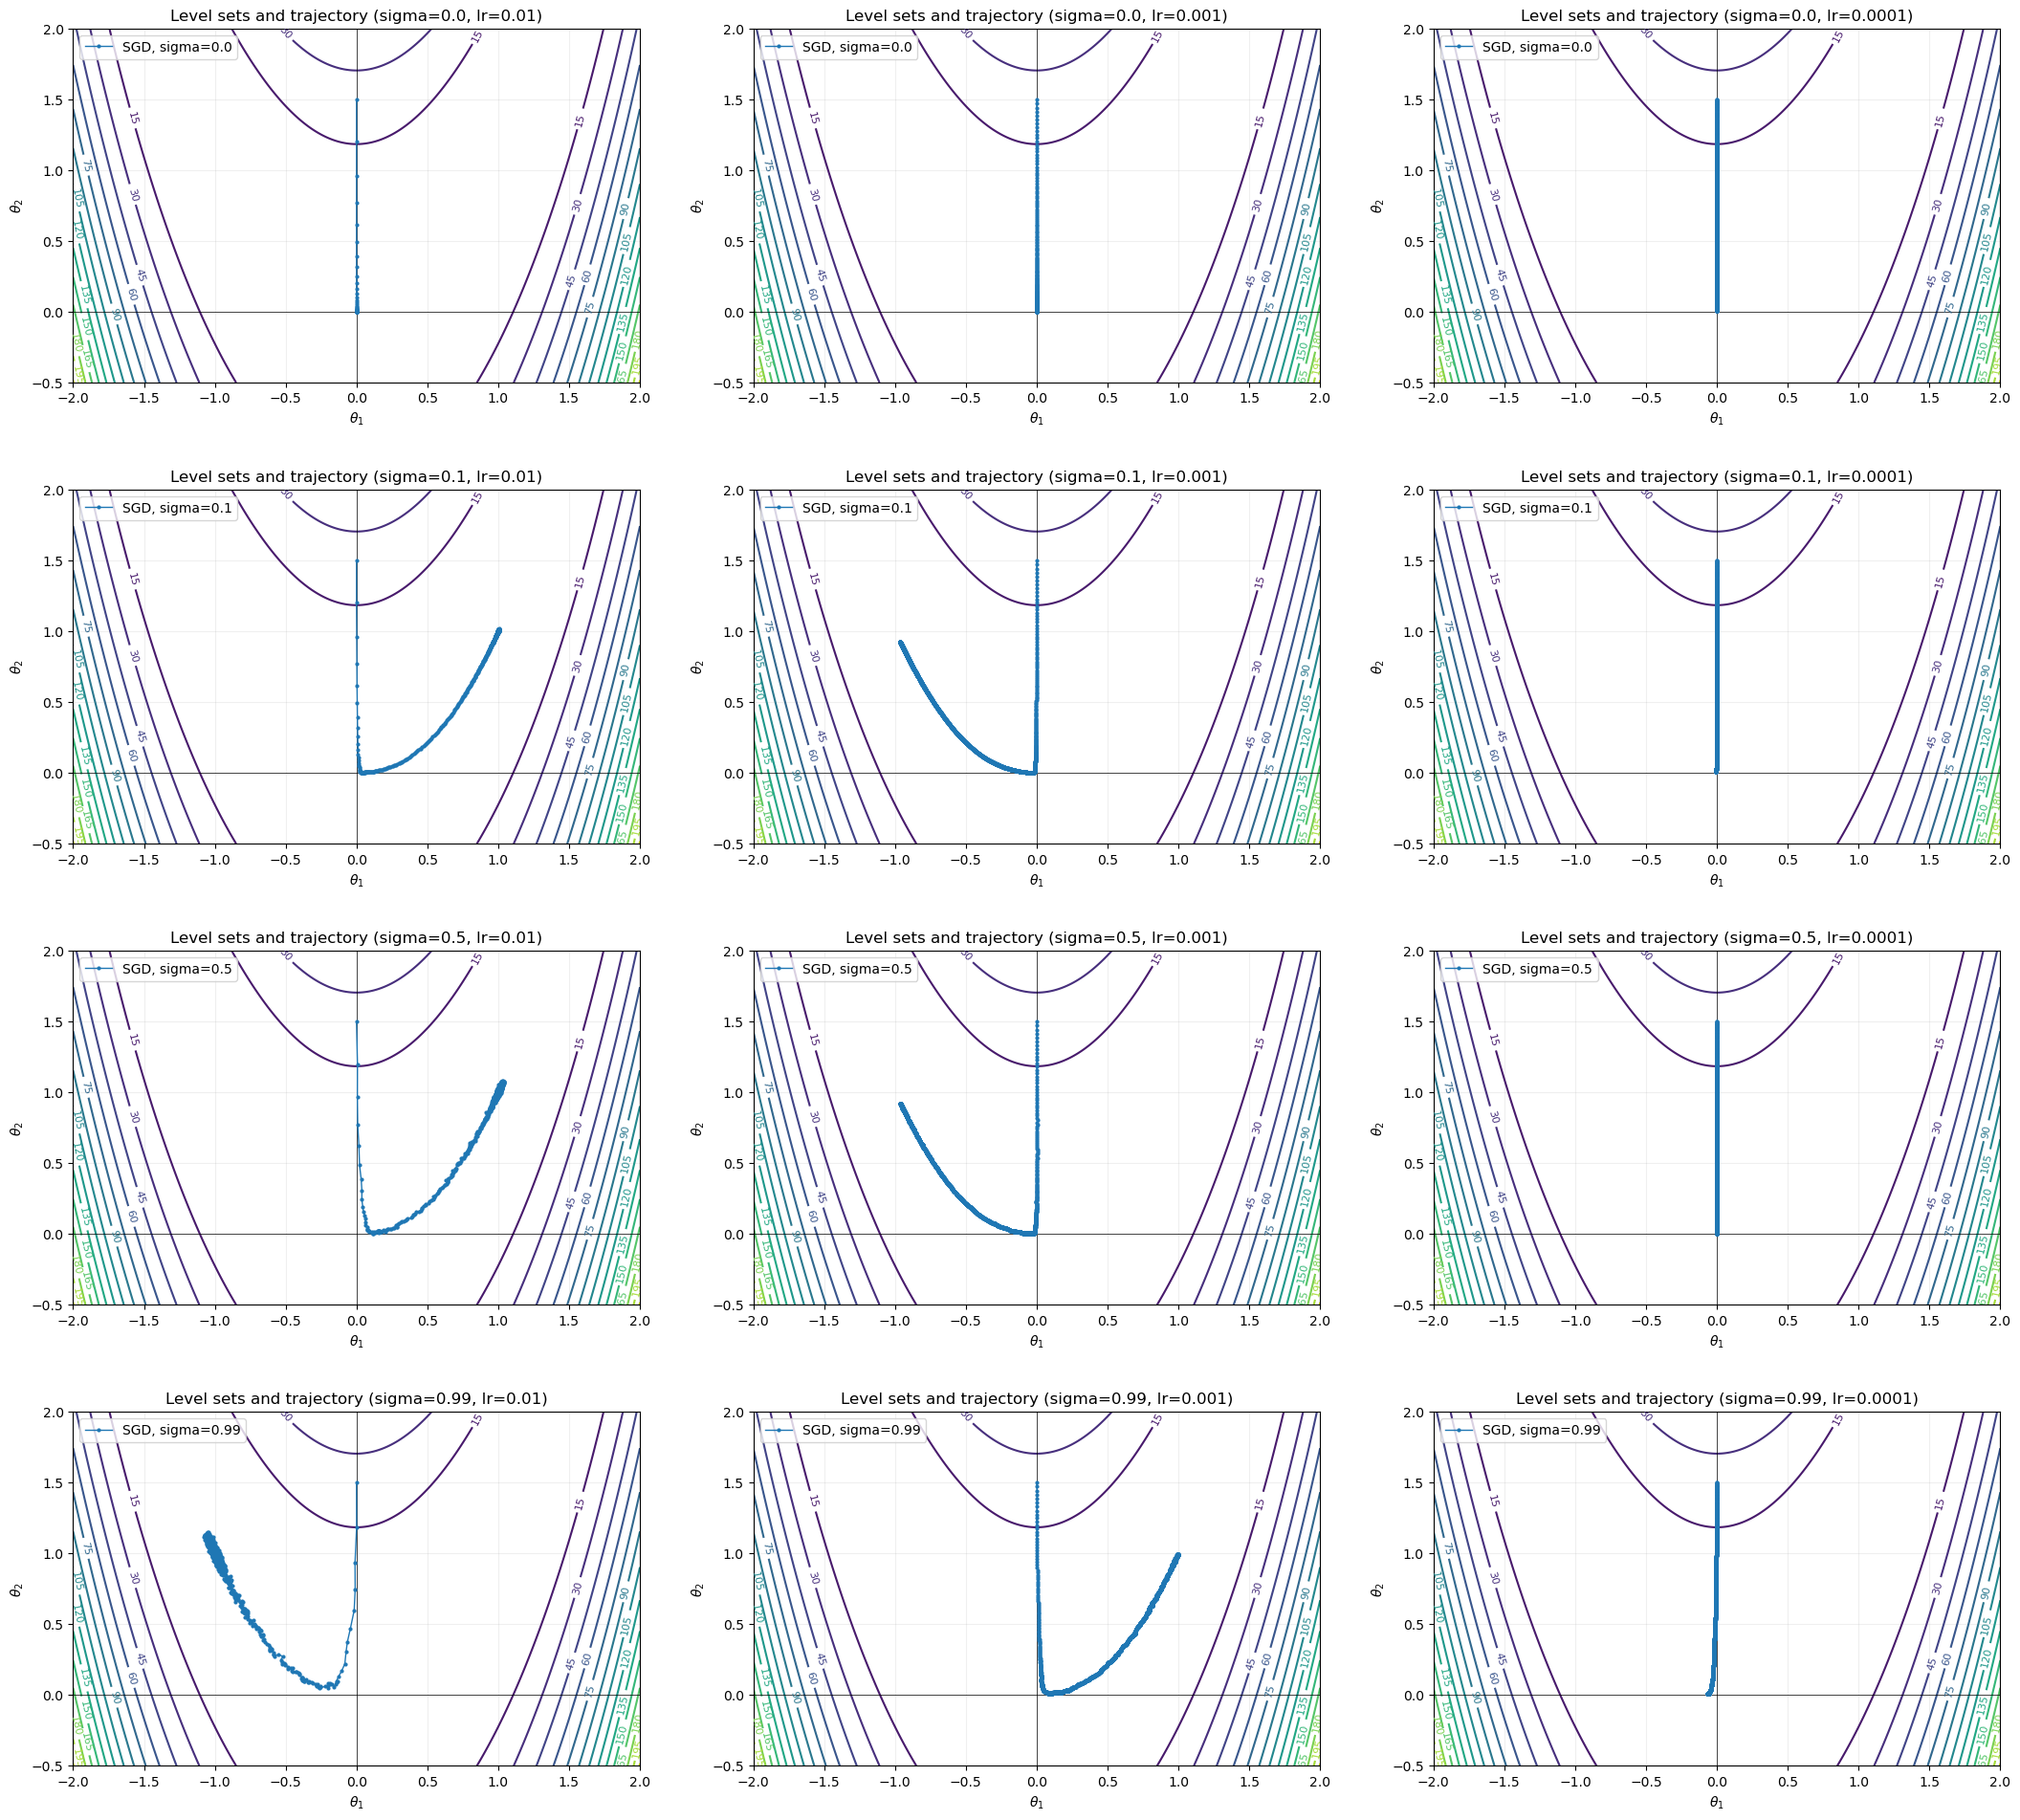

In [34]:
import numpy as np
import matplotlib.pyplot as plt

#EXERCISE3: SGD in 2D

def l(Theta):
    return (Theta[0]**2 - 1)**2 + 10*(Theta[1] - Theta[0]**2)**2

def grad_l(Theta):
    g1 = 4*(Theta[0]**3 - Theta[0]) + 40*(Theta[0]**3 - Theta[1]*Theta[0])
    g2 = 20*(Theta[1] - Theta[0]**2)
    return np.array([g1, g2])

def SGD_noise(l, grad_l, Theta0, sigma, batch_size=32, lr=1e-2, epochs=3000):
    losses = [l(Theta0)]
    Theta = Theta0.copy()
    thetas = [Theta.copy()]

    for epoch in range(epochs):
        eps = np.random.normal(0,sigma, size=2)
        g_real = grad_l(Theta)
        gk  = g_real + eps
        Theta = Theta - lr*gk

        losses.append(l(Theta))
        thetas.append(Theta.copy())
    return np.array(thetas), np.array(losses)

sigmas = [0.0, 0.1, 0.5, 0.99]
Theta0 = np.array([0.0, 1.5])
step_sizes = [1e-2,1e-3,1e-4,]
results = {}

for s in sigmas:
    results[s] = {}
    for step in step_sizes:
        thetas, losses = SGD_noise(l=l, grad_l=grad_l, Theta0=Theta0, sigma=s,lr=step)
        results[s][step] = {"thetas":thetas, "losses":losses}

def levelsets_l(xlim=(-2, 2), ylim=(-0.5, 2), ngrid=400, ncontours=16, title=None):
    xs = np.linspace(xlim[0], xlim[1], ngrid)
    ys = np.linspace(ylim[0], ylim[1], ngrid)
    X, Y = np.meshgrid(xs, ys)
    Z = (X**2 - 1)**2 + 10*(Y - X**2)**2  
    cs = plt.contour(X, Y, Z, levels=ncontours)
    plt.clabel(cs, inline=True, fontsize=8)
    plt.axhline(0, lw=0.5, color='k')
    plt.axvline(0, lw=0.5, color='k')
    plt.gca().set_aspect('equal', 'box')
    if title:
        plt.title(title)
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.grid(alpha=0.2)


fig, axes = plt.subplots(4, 3, figsize=(26, 24))
for idx, sigma in enumerate(sigmas):
    for idx2, step_size in enumerate(step_sizes):
        ax = axes[idx, idx2]
        plt.sca(ax)
        levelsets_l(title=f"Level sets and trajectory (sigma={sigma}, lr={step_size})")

        thetas = results[sigma][step_size]["thetas"]
        plt.plot(thetas[:,0], thetas[:,1], "o-", markersize=2,
                linewidth=1, label=f"SGD, sigma={sigma}")

        plt.legend()
plt.show()


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
Dataset size: 1338 samples, 4 features (including bias)
GD final Theta: [1.23999797e-17 2.78440109e-01 1.67225810e-01 5.40395370e-02]
SGD batch=1 final Theta: [ 0.06311353  0.39977653  0.26631559 -0.02137523]
SGD batch=10 final Theta: [0.00988048 0.27438016 0.18126379 0.06051884]
SGD batch=50 final Theta: [-0.00501027  0.28030895  0.1622008   0.05433882]
Perfect Theta: [2.58079297e-17 2.78440110e-01 1.67225809e-01 5.40395367e-02]


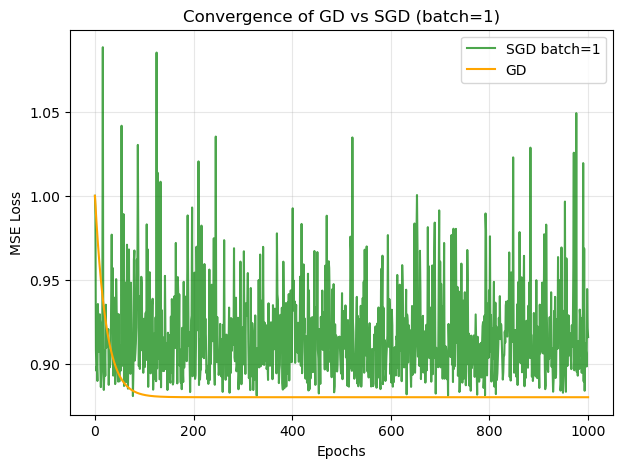

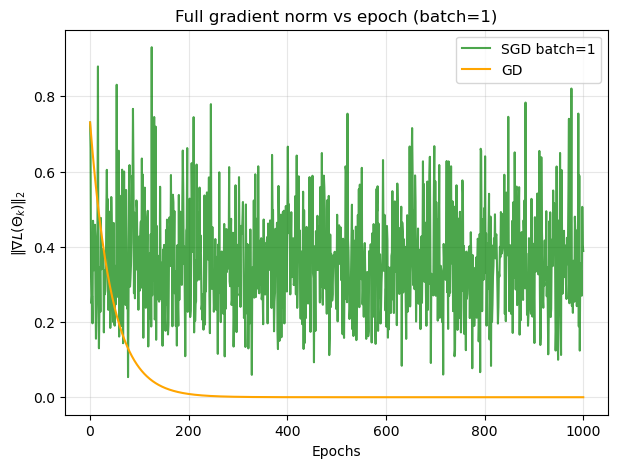

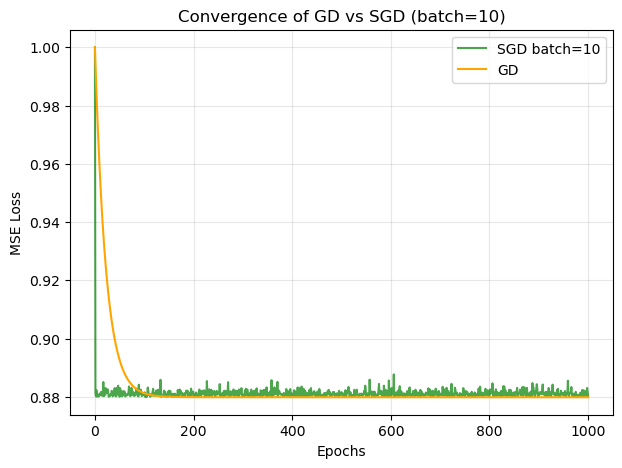

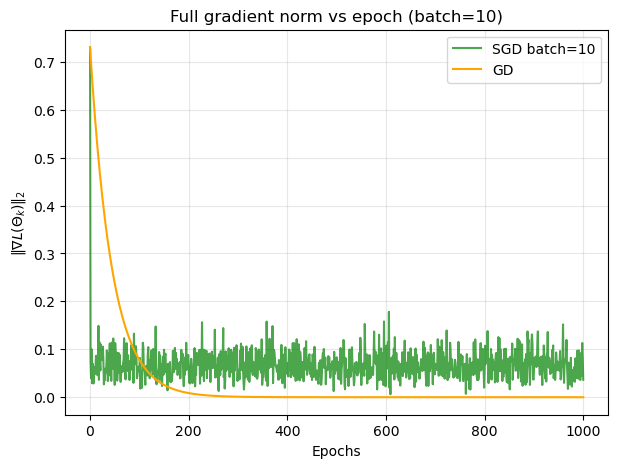

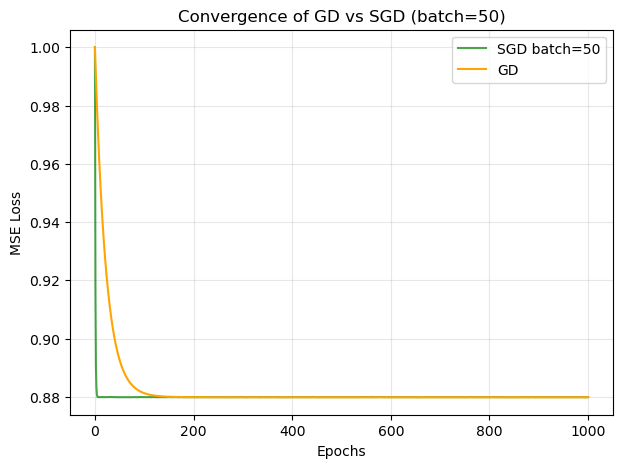

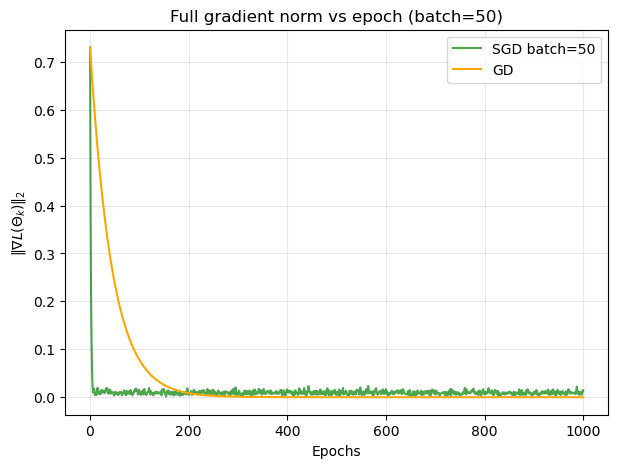

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#EXERCISE4: An ML Project with SGD

url = "insurance.csv"
train_data = pd.read_csv(url)
print(train_data.head())

features = ["age", "bmi", "children"]
X = train_data[features].values
Y = train_data["charges"].values.reshape(-1, 1)

X = (X - X.mean(axis=0)) / X.std(axis=0)
Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)

X = np.hstack([np.ones((X.shape[0], 1)), X])
N, d = X.shape
print(f"Dataset size: {N} samples, {d} features (including bias)")

def l(Theta, X, Y):
    return np.mean(np.square(X @ Theta - Y)) 

def grad_l(Theta, X, Y):
    return 2 * X.T @ (X @ Theta - Y) / X.shape[0]

def GD(l, grad_l, Theta0, X, Y, lr=1e-2, epochs=1000):
    thetas = [Theta0.copy()]
    theta = Theta0.copy()
    losses = [l(theta, X, Y)]
    grad_norms = [np.linalg.norm(grad_l(theta, X, Y))]

    for k in range(epochs):
        theta = theta - lr * grad_l(theta, X, Y)
        thetas.append(theta.copy())
        losses.append(l(theta,X,Y))
        grad_norms.append(np.linalg.norm(grad_l(theta, X, Y)))
    return np.array(thetas), np.array(losses), np.array(grad_norms)

def SGD(l, grad_l, Theta0, X, Y, batch_size, lr=1e-2, epochs=1000):
    losses = [l(Theta0, X, Y)]
    Theta = Theta0.copy()
    thetas = [Theta.copy()]
    grad_norms = [np.linalg.norm(grad_l(Theta, X, Y))]
    N = X.shape[0]
    
    for epoch in range(epochs):
        indices = np.random.permutation(N)  
        for start in range(0, N, batch_size):
            batch_idx = indices[start : start+batch_size]
            Xb = X[batch_idx]
            Yb = Y[batch_idx]

            g = grad_l(Theta, Xb, Yb)

            Theta = Theta - lr * g

        losses.append(l(Theta, X, Y))
        thetas.append(Theta.copy())
        grad_norms.append(np.linalg.norm(grad_l(Theta, X, Y)))
    return np.array(thetas), np.array(losses), np.array(grad_norms)

batch_sizes = [1, 10, 50]

Theta_gd, loss_gd, grad_norms_gd = GD(l, grad_l, np.zeros((d, 1)), X, Y)
sgd_results = {}
for b in batch_sizes:
    Thetas_sgd, loss_sgd, grad_norms_sgd = SGD(l, grad_l, np.zeros((d, 1)), X, Y, batch_size=b)
    sgd_results[b] = {"thetas": Thetas_sgd, "losses": loss_sgd, "grad_norms": grad_norms_sgd}


for b in batch_sizes:
    l = sgd_results[b]["losses"]
    t = sgd_results[b]["thetas"] 
    g = sgd_results[b]["grad_norms"]
    
    plt.figure(figsize=(7,5))
    plt.plot(l, label=f"SGD batch={b}", alpha=0.7, color="green")
    plt.plot(loss_gd, label="GD", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title(f"Convergence of GD vs SGD (batch={b})")
    plt.grid(alpha=0.3)

    plt.figure(figsize=(7,5))
    plt.plot(g, label=f"SGD batch={b}", alpha=0.7, color="green")
    plt.plot(grad_norms_gd, label="GD", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel(r"$\|\nabla L(\Theta_k)\|_2$")
    plt.legend()
    plt.title(f"Full gradient norm vs epoch (batch={b})")
    plt.grid(alpha=0.3)

print("GD final Theta:", Theta_gd[-1].ravel())
for b in batch_sizes:    
    print(f"SGD batch={b} final Theta:", sgd_results[b]["thetas"][-1].ravel())

print(f"Perfect Theta: {np.linalg.inv(X.T @ X) @ (X.T @ Y).ravel()}")
